In [1]:
# option for size of picture output 
set_plot_dimensions <- function(width_choice=9, height_choice=5, res_choice=200) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice, repr.plot.res=res_choice)
        }
set_plot_dimensions()

# Implementation of Bayesian inference using JAGS

## Determining the presence of an organism

There is a pond, and we want to determine if there is a tadpole within it knowning that we did not detected it during the survey.

It's a step forward with the previous problem. 

Now, we don't want the probability of detection, but the presence or absence of the tadpole with the knowdledge about the detection.

So, we have two **random variable** $detected$, that we know about from the experiment, and $present$ that we are looking for.

The question is: we know the value of $detected$, what is the value of $present$?

We are going to describe the 3 steps to implement it in a Bayesian inference solver.

1. The observation is the **random variable** $detected$, that is the results of detection ($1$ for detected, $0$ for non detected) following a Binomial law, of a single trial with probability $p(detected)$:

$$
detected \sim Binomial(n=1, p = p(detected))
$$

In our experiment $detected = 0$. This is the data.

2. using the Bayes rule $P(A) = P(A \vert B) P(B) + P(A \vert \neg B) P(\neg B)$, this probability of detection is given by:
$$
p(detected) = p(detected \vert present) * p(present) + p(detected \vert absent) * p(absent)
$$

We assume the detection is impossible in the absence of organism (no false positive) and therefore $p(detected \vert absent)=0$.

> **QUESTION**
>
> (1) - Using the assumption $p(detected \vert absent)=0$, is it true that it implies $p(present \vert detected)=1$?
>
> To help, Bayes Rules are:
> 
> $P(A) = P(A \vert B) P(B) + P(A \vert \neg B) P(\neg B)$
> 
> $P(A \vert B) = P(B \vert A) P(A) / P(B)$

In [2]:
# REPLY (1) HERE

# p(present \vert detected)?
#
# p(detected | absent) = 0
# p(detected) = ...
# p(present | detected) = ...


As a consequence, in this specific situation:
$$
p(detected) = p(detected \vert present) * p(present)
$$

Also, re-using the previous example, we assume that the probability of detecting the species given that it is present is:
$$
p(detected \vert present) = \frac{21}{52}
$$

Note: we see here how hierarchical model can be implemented. It's going to be an exercise.

Finally:
$$
p(detected) = \frac{21}{52} * p(present)
$$

3. Last steps, the fact that the organism is present or absent, is also a **random variable**, that we don't $present$ which follows a binomial law:
$$
present \sim Binomial(n=1, p = p(present))
$$

Note: We could have state that $p(present)$ follows a Beta distribution. But, keeping thing simple for now, we assume a non informative prior distribution $p(present) = 0.5$. We'll use it as an exercise here-after.

## Bayesian implementation with JAGS

JAGS stands for "Just Another Gibbs Sampler".

Once all this work is done, the model only needs to be coded in a BUGS-like language (here, the one used by JAGS), following the syntax rules described in the corresponding manual (see the internet link provided in the introduction). Please note that even though BUGS-like languages resemble the R language, it is not R programming. Instead, it involves declaring the model with the definition of nodes, links, and prior distributions, and the writing possibilities are much more limited compared to the R language.

In [3]:
library("coda")
library("rjags")

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



### Writting data

The data corresponding to the previously described model must be encoded as a list, using the same names as those used in the model, so that JAGS can establish the correct link between the two. In our example, this data list should include:
* `detected`, the observation.

In [4]:
data4jags = list("detected" = 0)

### Writting model

The model can be described in a text file or coded directly in the R script as a character string enclosed in quotation marks.
```
model{
    detected ~ dbern(prob_detect)
    prob_detect = 21/52 * present        
    present ~ dbern(prior)
    prior = 0.5        
}
```

In [5]:
cat(
    "model{
        detected ~ dbern(prob_detect)
        prob_detect = 21/52 * present        
        present ~ dbern(prior)
        prior = 0.5        
    }",
    file="src/tadpoles.txt"
)

### Initializing values of parameters

It is first recommended to define initial values for each incoming node of the DAG and each Markov chain, in a list of the same type as the one defining the data, named 'ini' in the example below. This is important for the optimal use of the Gelman and Rubin convergence criterion, which assumes chains starting from initial values that are over-dispersed relative to the posterior distributions. 

In our example, if we choose to run 3 chains, then, this can be done as follows:

```r
ini1 <- list(present = 0.01)
ini2 <- list(present = 0.5)
ini3 <- list(present = 0.99)
ini <- list(ini1, ini2, ini3)
```

If we do not specify initial values in JAGS, it will generally define them automatically based on the prior distributions, but for each parameter, it will assign the same initial value to all chains. This should change in the next version of JAGS (version 5), which is expected to automatically offer different initial values (this is a delicate procedure to implement: simply drawing initial values randomly from the prior distributions without excluding extreme values would lead to many numerical errors).

For simplification, here, we do not init the values.

### Implementation with "rjags"

It is then necessary to load the `rjags` library to use the `jags.model` function, which defines an object representing a Bayesian model with its data and a fixed number of chains to simulate. The following arguments need to be provided to this function:

* `file`, the name of the text file in which the model has been coded, or if the model has been coded directly as a character string in the R script, the 'textConnection()' function applied to the name of the character string.
* `data`, the name of the dataset previously defined in the R script.
* `inits`, a list of initial values for the incoming nodes, as specified.

The `jags.model` function will verify the integrity of the coded model and initiate `n.adapt` (fixed by default at 1000) initial iterations that are used to adapt the algorithm for generating subsequent MCMC (Markov Chain Monte Carlo) samples most efficiently. These initial iterations are not yet part of the MCMC process.

In [6]:
model = jags.model(
    file = "src/tadpoles.txt",
    data = data4jags,
    n.chains = 3
)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1
   Unobserved stochastic nodes: 1
   Total graph size: 7

Initializing model



A burn-in phase is then necessary to initialize the simulations. The simulations during this burn-in phase will not be considered when estimating the posterior distributions of the parameters.

The length of the burn-in phase may vary depending on the convergence speed of the algorithm for a given Bayesian model. You can start with a default burn-in phase of 5000 iterations and increase it if necessary. The function to use for generating these initial iterations is `update`.

In [7]:
update(model, 5000)

After the burn-in phase, you can use the `coda.samples` function to generate `n.iter` additional iterations and retain the simulated values of the nodes of interest (the names are specified as shown in the function) to characterize the posterior distribution of these nodes.

In [8]:
n_iter = 5000
mcmc = coda.samples(model, c("present"), n.iter = n_iter)

> **QUESTIONS**:
>
> (2) - Explore `mcmc`object: what returns `class(mcmc)`?
> 
> (3) - What is `length(mcmc)`?
> 
> (4) - Plot the histogram of the chains.
> 
> (5) - What is the mean of all mcmc chains?
>
> (6) - Test `summary(mcmc)`.

In [9]:
# REPLY (2) HERE
# class(mcmc)


In [10]:
# REPLY (3) HERE
# length(mcmc)


In [11]:
# REPLY (4) HERE


In [12]:
# REPLY (5) HERE
# mean of all mcmc chains


In [13]:
# REPLY (6) HERE
# summary(mcmc)


#### Convergence criterion

JAGS also offers the calculation of several convergence criteria. The Gelman and Rubin criterion, known as the reduction in variance, is based on a comparison of variances and is somewhat analogous to analysis of variance, inquiring whether there is a chain effect on the simulated values. The criterion is calculated for each model parameter as the square root of the ratio between the variance of its marginal posterior distribution (estimated by a linear combination of inter- and intra-chain variances) and the intra-chain variance. It approaches 1 when the inter-chain variance is negligible compared to the intra-chain variance (which is the desired condition). The 'gelman.diag' function is used to calculate this criterion.

In [14]:
gelman.diag(mcmc)

Potential scale reduction factors:

        Point est. Upper C.I.
present          1          1


A graphical function also allows you to observe how this criterion changes as you increase the calculation window, i.e., the number of iterations used to calculate it. By default, the first value on the graph is calculated with the first 50 iterations. The 'gelman.plot' function is used to create this graphical representation. This graph enables you to determine if convergence occurs in the early iterations and verify that the number of iterations is sufficient for the Gelman and Rubin criterion to converge and approach a value of 1.

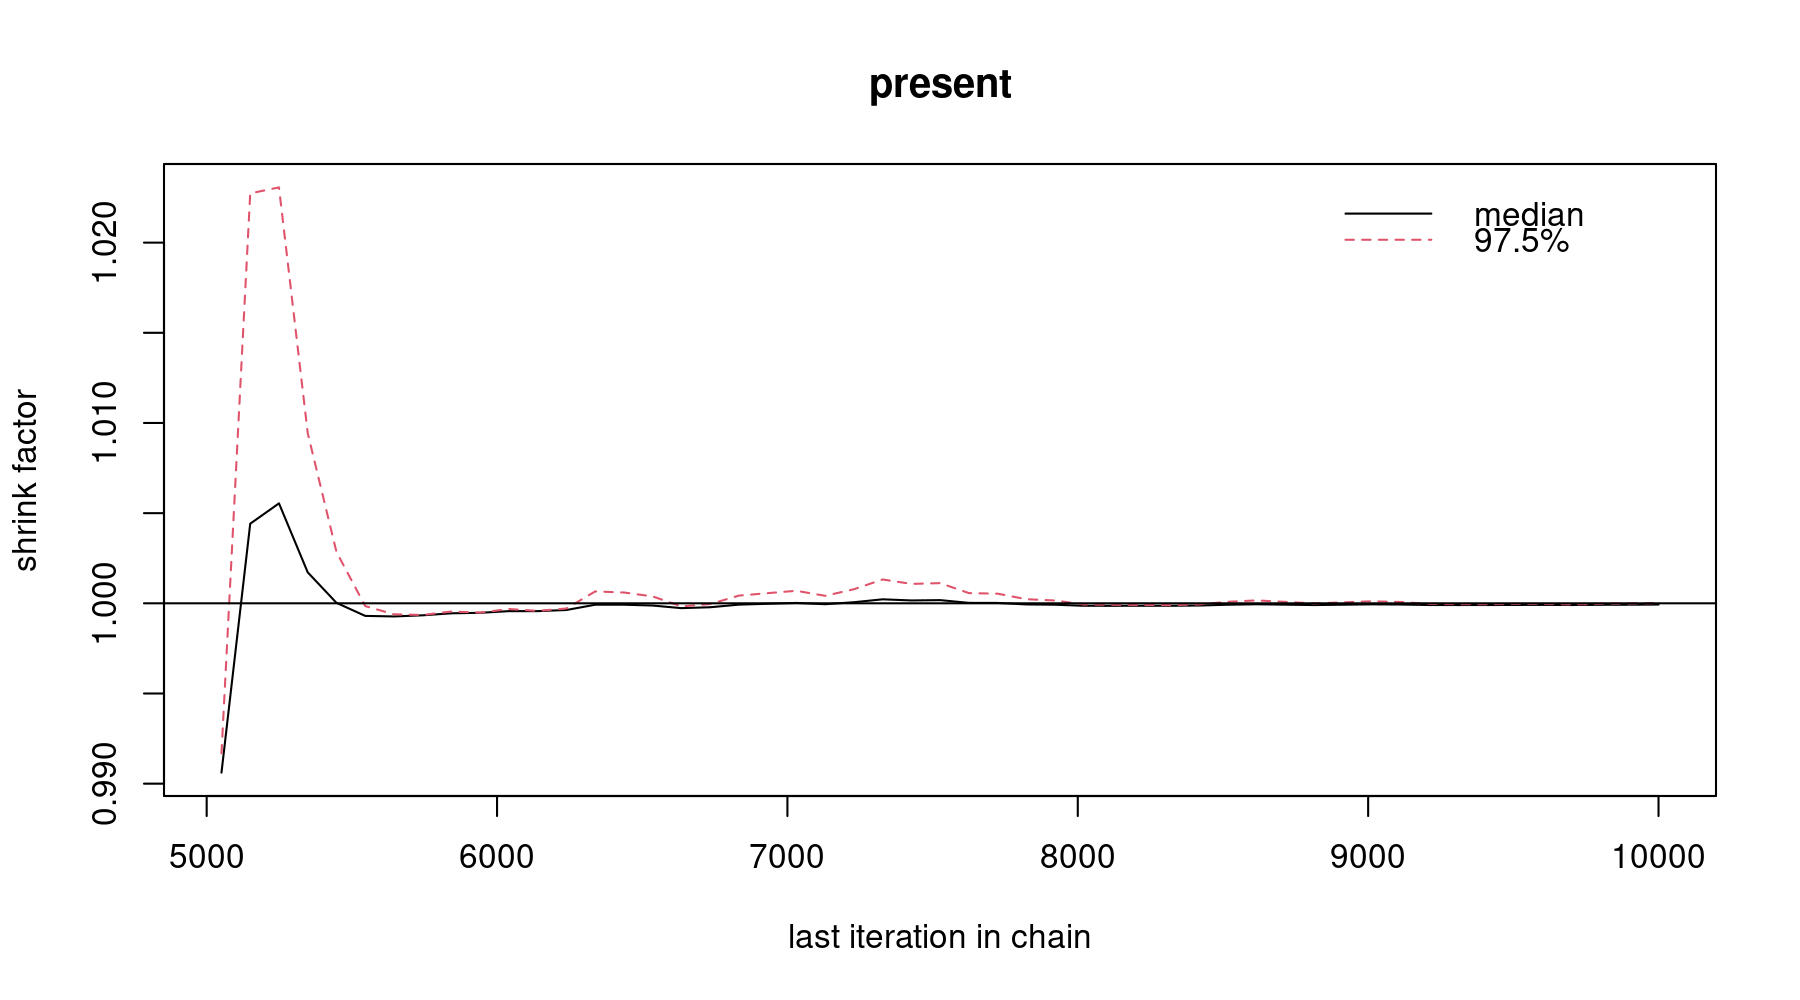

In [15]:
gelman.plot(mcmc)

In [16]:
# Compute DIC
dic_result = dic.samples(model, n.iter = n_iter)
dic_result

Mean deviance:  0.3828 
penalty NaN 
Penalized deviance: NaN 

## Conclusion

Back to the initial question:

*we want to determine if there is a tadpole within it knowning that we did not detected it during the survey.*

We set the question as:
* We know the value of $detected$, what is the **value** of $present$?
In a more Bayesian way, we would say:
* We know the value of $detected$, what is the **distribution** of $present$?

> **QUESTION**:
>
> (7) - What is the distribution of `present`?

In [17]:
# REPLY (7) HERE
# Distribution of `present`


Since we consider a bernouilli trial (a special case of the binomial distribution where a single trial is conducted), the probability of the success is the mean of the random variable. In mathematical word: 

If $X \sim Binomial(1,p)$ then $\mathbb{E}(X) = p$ 

> **QUESTION**:
>
> (8) - What is the probability of `present` knowing we did not detected it during the survey?

In [18]:
# REPLY (8) HERE
# Probability of `present`
